In [1]:
%matplotlib inline

In [2]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
mpl.rcParams['savefig.dpi'] = 180

In [30]:
OPTIONS = {'FSM': 'results_fsm.txt', 'Snake': 'results_snake.txt', 'Tetris': 'results_tetris.txt', 'Synth':'results_synth.txt'}
import ipywidgets as widgets
from IPython.display import display
s = widgets.Dropdown(options=OPTIONS)
display(s)

In [39]:
s.value

'results_synth.txt'

# Select Benchmark:

In [40]:
data = genfromtxt(s.value, usecols=(1,2,3))
#data = genfromtxt('results_tetris.txt', usecols=(1,2,3))
#data = genfromtxt('results_fsm.txt', usecols=(1,2,3))
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
data.sort(axis=0)
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

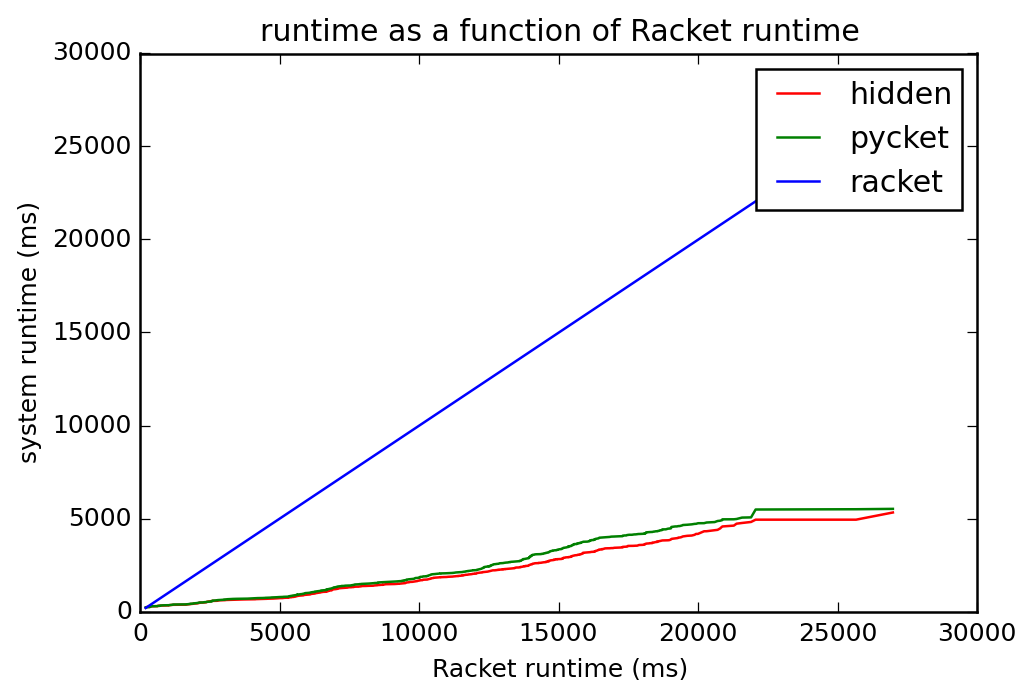

In [41]:
# Runtime of Pycket as a function of Racket
pylab.plot(racket, hidden, 'r', label='hidden')
pylab.plot(racket, pycket, 'g', label='pycket')
pylab.plot(racket, racket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend()

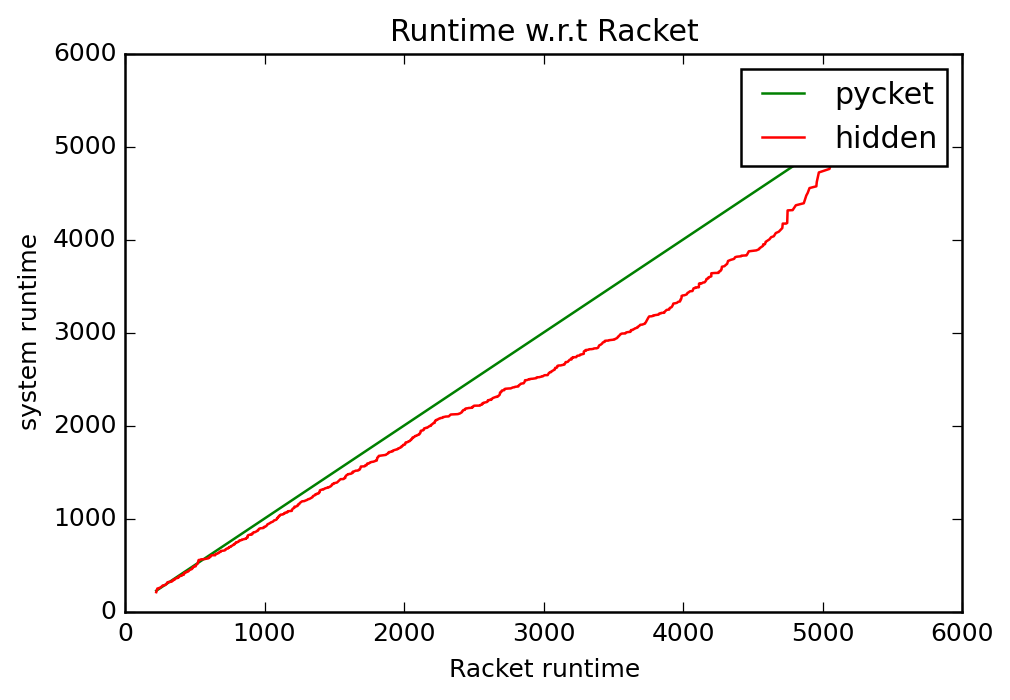

In [42]:
pylab.plot(pycket, pycket, 'g', label='pycket')
pylab.plot(pycket, hidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Racket')
pylab.xlabel('Racket runtime')
pylab.ylabel('system runtime')
pylab.legend()

In [43]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / hidden_untyped
pycket_slowdown = pycket / pycket_untyped
racket_slowdown = racket / racket_untyped

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, float(len(data)) * 100)]
    print "Max overhead:    %0.2f" % max(data)
    print "Mean overhead:   %0.2f" % numpy.mean(data)
    print "300-deliverable: %d (%0.2f%%)" % (th, th / float(len(data)) * 100)
    print "300/1000-usable: %d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)


# Slowdown Summary Stats

In [44]:
DataFrame({'racket':racket_slowdown, 'pycket':pycket_slowdown, 'hidden':hidden_slowdown}).describe()

,hidden,pycket,racket
count,1024.000000,1024.000000,1024.000000
mean,7.297794,9.105063,53.393127
std,4.030616,5.261675,26.227077
min,0.818898,0.965368,1.000000
25%,3.768701,4.519481,32.192708
50%,7.202756,8.790043,55.541667
75%,9.952756,12.950216,72.932292
max,20.956693,23.887446,140.479167


# Deliverability Stats

In [45]:
lst = [["System", "Max overhead", "Mean overhead", "300-deliverable", "300/1000-usable"]]
lst.append(["hidden"] + compute_deliverable(hidden_slowdown))
lst.append(["pycket"] + compute_deliverable(pycket_slowdown))
lst.append(["racket"] + compute_deliverable(racket_slowdown))

make_table(map(list, zip(*lst)))

System,hidden,pycket,racket
Max overhead,20.9567,23.8874,140.4792
Mean overhead,7.2978,9.1051,53.3931
300-deliverable,190 (18.55%),127 (12.40%),9 (0.88%)
300/1000-usable,582 (102400.00%),499 (102400.00%),43 (102400.00%)


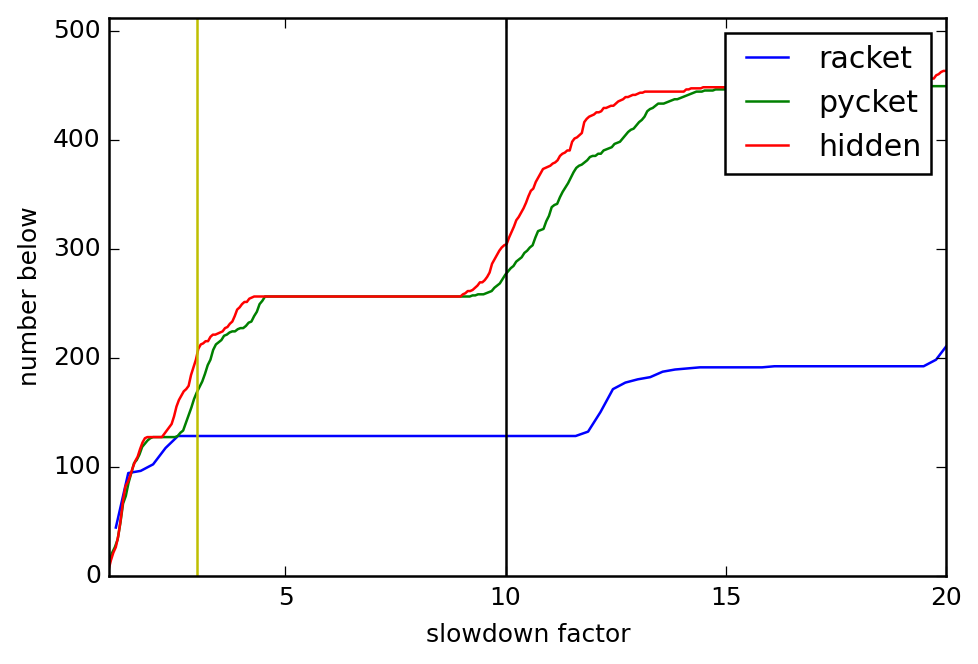

In [38]:
for data, color, label in [(racket_slowdown, 'b', 'racket'),
                               (pycket_slowdown, 'g', 'pycket'),
                               (hidden_slowdown, 'r', 'hidden')]:
    counts, bin_edges = numpy.histogram(data, bins=len(data))
    cdf = numpy.cumsum(counts)
    pylab.plot(bin_edges[1:], cdf, color=color, label=label)
pylab.axvline(3, color='y')
pylab.axvline(10, color='k')
pylab.xlabel('slowdown factor')
pylab.xlim((1,20))
pylab.ylim((0,len(racket)))
pylab.ylabel('number below')
pylab.legend()